In [1]:
import os
import re
import sys
import time
import glob

import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import multiprocessing as mp

import requests
from getpass4 import getpass

import tendrils
from tendrils import api, utils

#tendrils.utils.copy_from_other_config('config.ini')

In [2]:
tendrils.utils.create_config()

Enter API token to be saved into config: 002df844c90bdf94c9da5a97112a9e01
Enter photometry output directory absolute path: data
Enter local data archive directory absolute path: data


For more info about the ATLAS API, go to: https://fallingstar-data.com/forcedphot/apiguide/
This code is adapted from their code.

In [3]:
def get_token(user, password):
    BASEURL = "https://fallingstar-data.com/forcedphot"
    
    if os.environ.get('ATLASFORCED_SECRET_KEY'):
        token = os.environ.get('ATLASFORCED_SECRET_KEY')
        print('Using stored token')
    else:
        data = {'username': user, 'password': password}
        resp = requests.post(url=f"{BASEURL}/api-token-auth/", data=data)

        if resp.status_code == 200:
            token = resp.json()['token']
            print(f'Your token is {token}')
            print('Store this by running/adding to your .zshrc file:')
            print(f'export ATLASFORCED_SECRET_KEY="{token}"')
        else:
            print(f'ERROR {resp.status_code}')
            print(resp.text)
            sys.exit()
            
    return token

def get_headers(token):
    
    headers = {'Authorization': f'Token {token}', 
               'Accept': 'application/json'}
    
    return headers

def submit_task(ra, dec, headers, mjd_min=None, mjd_max=None):
    BASEURL = "https://fallingstar-data.com/forcedphot"
    
    task_url = None
    while not task_url:
        with requests.Session() as s:
            resp = s.post(f"{BASEURL}/queue/", headers=headers, data={
                'ra': ra, 'dec': dec, 'send_email': False,
                'mjd_min':mjd_min, 'mjd_max':mjd_max})

            if resp.status_code == 201:  # successfully queued
                task_url = resp.json()['url']
                print(f'The task URL is {task_url}')
            elif resp.status_code == 429:  # throttled
                message = resp.json()["detail"]
                print(f'{resp.status_code} {message}')
                t_sec = re.findall(r'available in (\d+) seconds', message)
                t_min = re.findall(r'available in (\d+) minutes', message)
                if t_sec:
                    waittime = int(t_sec[0])
                elif t_min:
                    waittime = int(t_min[0]) * 60
                else:
                    waittime = 10
                print(f'Waiting {waittime} seconds')
                time.sleep(waittime)
            else:
                print(f'ERROR {resp.status_code}')
                print(resp.text)
                sys.exit()
                
    return task_url

def get_url(task_url, headers):
    
    result_url = None
    taskstarted_printed = False
    while not result_url:
        with requests.Session() as s:
            resp = s.get(task_url, headers=headers)

            if resp.status_code == 200:  # HTTP OK
                if resp.json()['finishtimestamp']:
                    result_url = resp.json()['result_url']
                    print(f"Task is complete with results available at {result_url}")
                    if result_url is None:
                        return None
                elif resp.json()['starttimestamp']:
                    if not taskstarted_printed:
                        print(f"Task is running (started at {resp.json()['starttimestamp']})")
                        taskstarted_printed = True
                    time.sleep(2)
                else:
                    print(f"Waiting for job to start (queued at {resp.json()['timestamp']})")
                    time.sleep(4)
            else:
                print(f'ERROR {resp.status_code}')
                print(resp.text)
                sys.exit()
                
    return result_url

def get_lightcurves(ra, dec, user, password, mjd_min=None, mjd_max=None):
    
    token = get_token(user, password)
    headers = get_headers(token)
    task_url = submit_task(ra, dec, headers, mjd_min, mjd_max)
    result_url = get_url(task_url, headers)
    if result_url is None:
        return None
    
    with requests.Session() as s:
        textdata = s.get(result_url, headers=headers).text

    lc_df = pd.read_csv(StringIO(textdata.replace("###", "")), 
                        delim_whitespace=True)
    
    return lc_df

In [23]:
targets_list = api.get_targets()
targets_df = pd.DataFrame(targets_list)

flows_df = targets_df[targets_df.project=='flows']
flows_df = flows_df[flows_df.target_status=='target']
# convert ISO time to MJD
flows_df.discovery_date = [time.mjd if time is not None else None
                           for time in flows_df.discovery_date]
flows_df.shape

(514, 15)

In [8]:
user = 't.e.muller-bravo'
password = getpass('Password:')

In [27]:
existing_sne = [file.split('/')[-1][:-4] for file in glob.glob('data/*')]
print(len(existing_sne))
#existing_sne = existing_sne + ['2009D', '2021aefx', '2022enb', '2022huk', '2022hot']  # add SNe that return None

510


In [28]:
for index, row in flows_df.iterrows():
    name = row.target_name
    ra, dec = row.ra, row.decl
    dd = row.discovery_date
    if np.isnan(dd) or dd is None:
        print(f'{name} has no discovery date')
        mjd_min = 58800
        mjd_max = None
    else:
        mjd_min = dd-20
        mjd_max = dd+120
    
    if name not in existing_sne:
        print(name)
        lc_df = get_lightcurves(ra, dec, user, password, 
                                mjd_min, mjd_max)
        if lc_df is None:
            print(f'{name} returned None for the task')
            continue
        lc_file = os.path.join('data', f'{name}.csv')
        lc_df.to_csv(lc_file, index=False)

2020szr has no discovery date
2020tcp has no discovery date
2020thn has no discovery date
2020tnw has no discovery date
2020tdp has no discovery date
2020stk has no discovery date
2020svi has no discovery date
2020tfd has no discovery date
2020svo has no discovery date
2020tfg has no discovery date
2020aakx has no discovery date
2021mvl has no discovery date
2009D
Your token is 6545448b543e51217af852e5878fdf4b13d58aec
Store this by running/adding to your .zshrc file:
export ATLASFORCED_SECRET_KEY="6545448b543e51217af852e5878fdf4b13d58aec"
The task URL is https://fallingstar-data.com/forcedphot/queue/222928/
Waiting for job to start (queued at 2022-07-07T13:26:35Z)
Waiting for job to start (queued at 2022-07-07T13:26:35Z)
Waiting for job to start (queued at 2022-07-07T13:26:35Z)
Waiting for job to start (queued at 2022-07-07T13:26:35Z)
Waiting for job to start (queued at 2022-07-07T13:26:35Z)
Waiting for job to start (queued at 2022-07-07T13:26:35Z)
Waiting for job to start (queued at 2

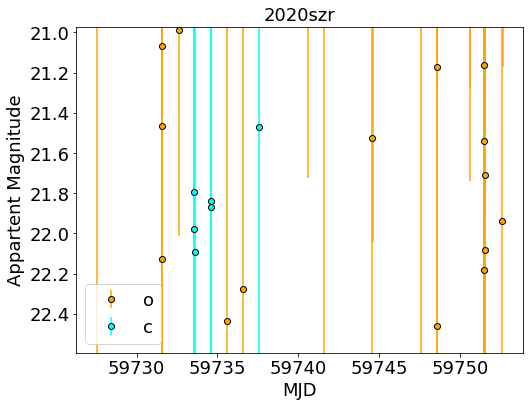

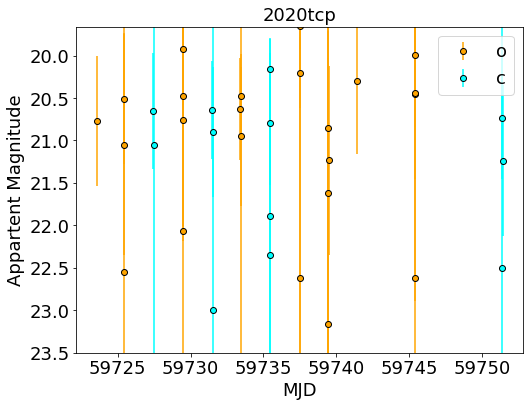

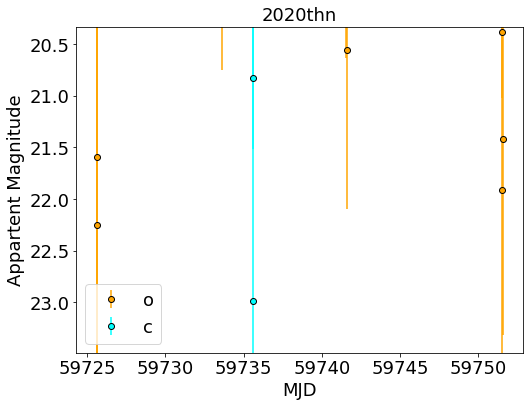

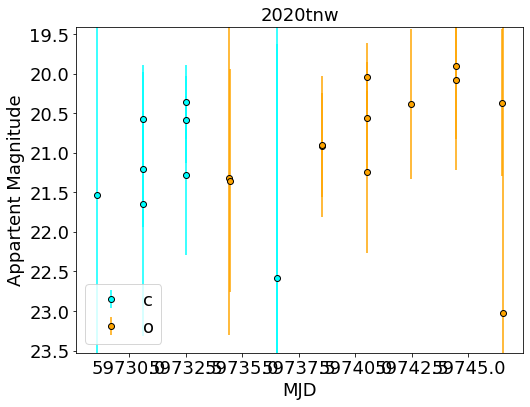

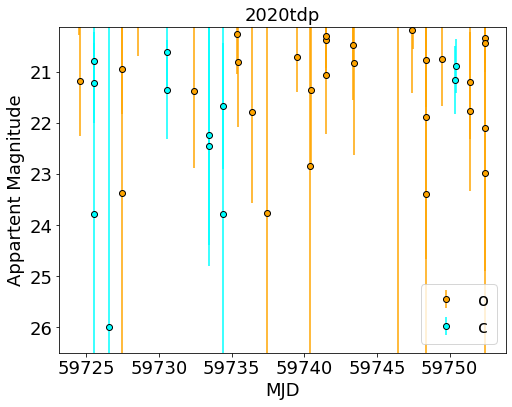

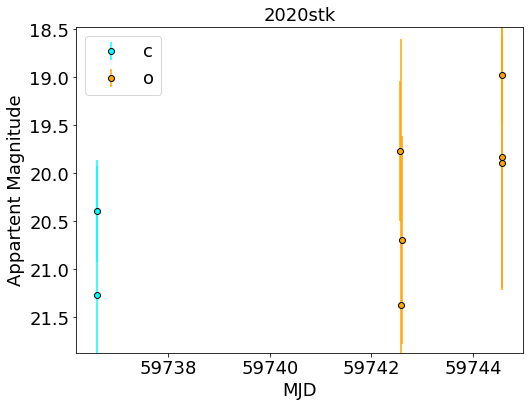

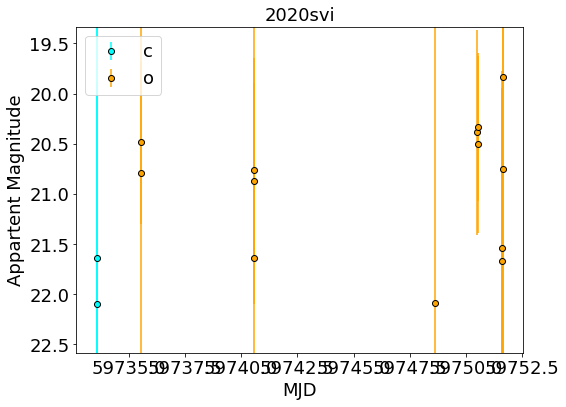

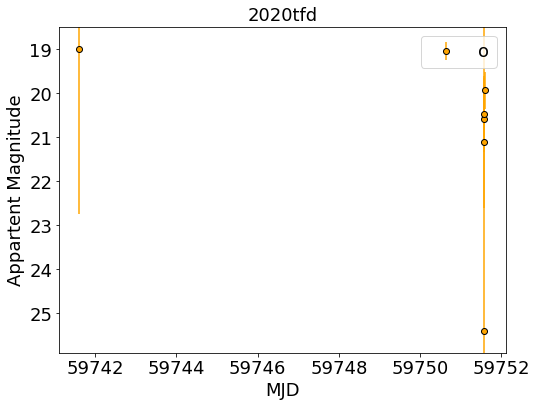

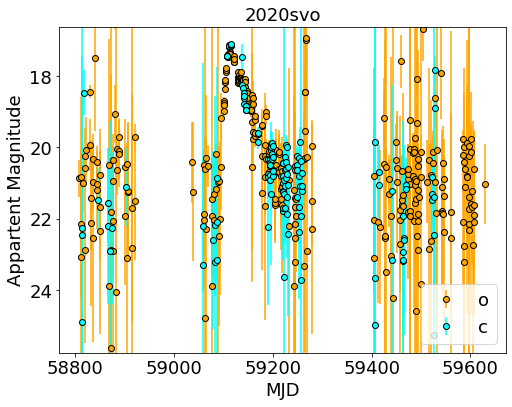

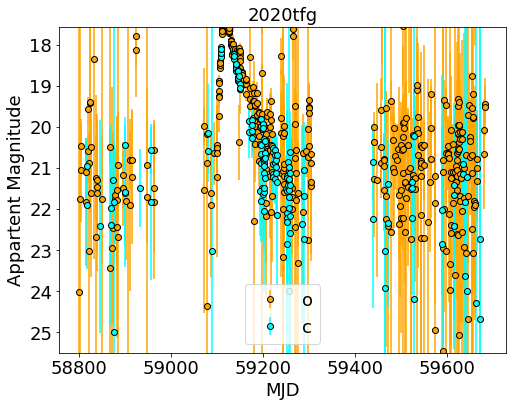

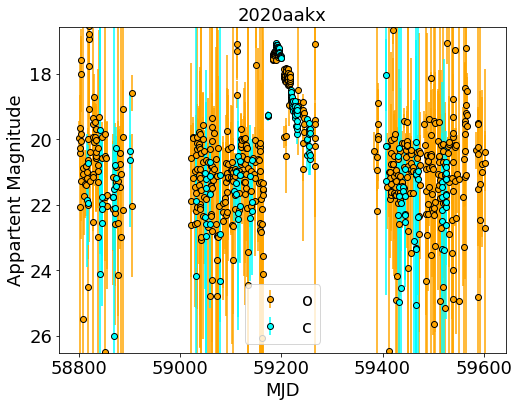

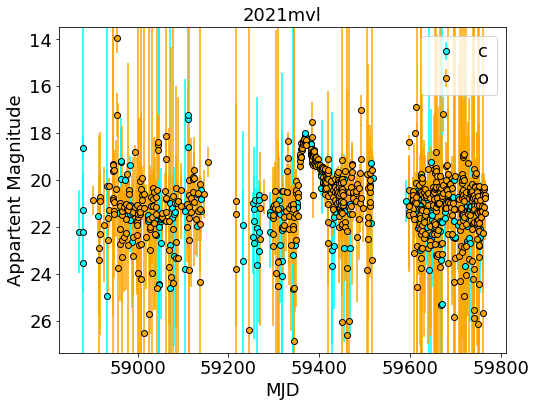

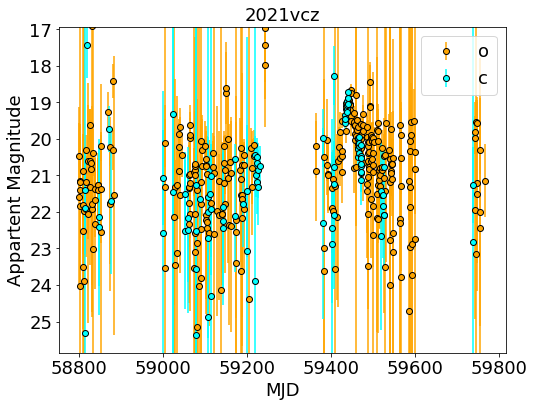

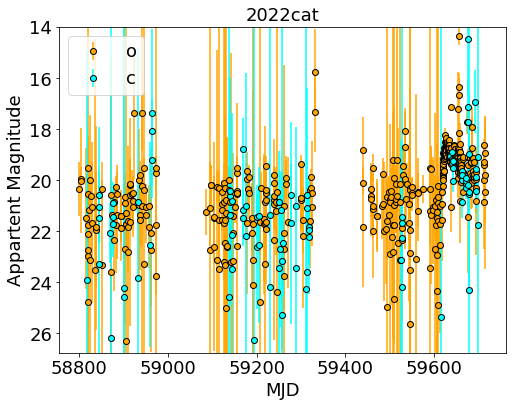

In [26]:
# SNe with no discovery dates
colours = {'c':'cyan', 'o':'orange'}

for index, row in flows_df.iterrows():
    name = row.target_name
    ra, dec = row.ra, row.decl
    dd = row.discovery_date
    if np.isnan(dd) or dd is None:
        lc_file = os.path.join('data', f'{name}.csv')
        lc_df = pd.read_csv(lc_file)
        
        fig, ax = plt.subplots(figsize=(8, 6))
        for filt in lc_df.F.unique():
            lc = lc_df[lc_df.F==filt]
            lc = lc[lc.m>0]
            ax.errorbar(lc.MJD, lc.m, lc.dm, 
                        fmt='o', label=filt, c=colours[filt], mec='k')

        ax.set_title(name, fontsize=18)
        ax.set_ylabel('Appartent Magnitude', fontsize=18)
        ax.set_xlabel('MJD', fontsize=18)
        ax.tick_params(labelsize=18)
        ax.legend(fontsize=18)
        ax.set_ylim(lc.m.min()-0.5, lc.m.max()+0.5)
        ax.invert_yaxis()
        plt.show()